# 🎮 Aprendizaje por Refuerzo con Pacman

## Introducción

En este notebook vamos a crear un agente de **Aprendizaje por Refuerzo** que aprenderá a jugar Pacman desde cero.

### ¿Qué es el Aprendizaje por Refuerzo?

Es un tipo de machine learning donde un **agente** aprende a tomar decisiones mediante:
- **Estados**: Situación actual del juego
- **Acciones**: Movimientos que puede hacer (arriba, abajo, izquierda, derecha)
- **Recompensas**: Puntos positivos o negativos según sus acciones
- **Q-Learning**: Algoritmo que aprende qué acción es mejor en cada estado

### Pasos del Proyecto:
1. Crear un entorno simplificado de Pacman
2. Implementar el algoritmo Q-Learning
3. Entrenar al agente
4. Visualizar el progreso
5. Ver al agente jugar

## Paso 1: Instalación y Importación de Librerías

In [ ]:
# Instalación de dependencias (ejecutar solo una vez)
# !pip install pygame gymnasium numpy matplotlib

In [1]:
import pygame
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from IPython.display import clear_output
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Paso 2: Crear el Entorno de Pacman

Vamos a crear un entorno simplificado de Pacman usando **Gymnasium** (el sucesor de OpenAI Gym).

### Características del entorno:
- Grid de 10x10
- Pacman se mueve en 4 direcciones
- Fantasmas que se mueven aleatoriamente
- Puntos (dots) que recolectar
- Sistema de recompensas

In [2]:
class PacmanEnv(gym.Env):
    """Entorno simplificado de Pacman compatible con Gymnasium"""
    
    metadata = {'render_modes': ['human', 'rgb_array'], 'render_fps': 10}
    
    def __init__(self, grid_size=10, num_ghosts=2, render_mode=None):
        super().__init__()
        
        self.grid_size = grid_size
        self.num_ghosts = num_ghosts
        self.render_mode = render_mode
        
        # Espacio de acciones: 0=arriba, 1=derecha, 2=abajo, 3=izquierda
        self.action_space = spaces.Discrete(4)
        
        # Espacio de observación: posición de pacman, fantasmas y puntos
        # [pacman_x, pacman_y, ghost1_x, ghost1_y, ..., dots_remaining]
        obs_size = 2 + (2 * num_ghosts) + 1
        self.observation_space = spaces.Box(
            low=0, high=grid_size, shape=(obs_size,), dtype=np.float32
        )
        
        # Pygame setup
        self.cell_size = 50
        self.window_size = grid_size * self.cell_size
        self.window = None
        self.clock = None
        
        # Colores
        self.BLACK = (0, 0, 0)
        self.YELLOW = (255, 255, 0)
        self.RED = (255, 0, 0)
        self.WHITE = (255, 255, 255)
        self.BLUE = (0, 0, 255)
        
    def reset(self, seed=None, options=None):
        """Reinicia el entorno al estado inicial"""
        super().reset(seed=seed)
        
        # Posición inicial de Pacman (centro)
        self.pacman_pos = np.array([self.grid_size // 2, self.grid_size // 2])
        
        # Posiciones iniciales de los fantasmas (aleatorias)
        self.ghost_positions = []
        for _ in range(self.num_ghosts):
            while True:
                pos = np.array([random.randint(0, self.grid_size-1), 
                              random.randint(0, self.grid_size-1)])
                # Asegurar que no estén en la posición de Pacman
                if not np.array_equal(pos, self.pacman_pos):
                    self.ghost_positions.append(pos)
                    break
        
        # Crear grid de puntos (todos los lugares excepto pacman y fantasmas)
        self.dots = np.ones((self.grid_size, self.grid_size), dtype=bool)
        self.dots[self.pacman_pos[0], self.pacman_pos[1]] = False
        for ghost_pos in self.ghost_positions:
            self.dots[ghost_pos[0], ghost_pos[1]] = False
        
        self.total_dots = np.sum(self.dots)
        self.steps = 0
        self.max_steps = 200
        
        return self._get_obs(), {}
    
    def _get_obs(self):
        """Construye el vector de observación"""
        obs = list(self.pacman_pos)
        for ghost_pos in self.ghost_positions:
            obs.extend(ghost_pos)
        obs.append(np.sum(self.dots))
        return np.array(obs, dtype=np.float32)
    
    def step(self, action):
        """Ejecuta una acción y retorna el nuevo estado"""
        self.steps += 1
        
        # Mover Pacman según la acción
        new_pos = self.pacman_pos.copy()
        if action == 0:  # Arriba
            new_pos[1] = max(0, new_pos[1] - 1)
        elif action == 1:  # Derecha
            new_pos[0] = min(self.grid_size - 1, new_pos[0] + 1)
        elif action == 2:  # Abajo
            new_pos[1] = min(self.grid_size - 1, new_pos[1] + 1)
        elif action == 3:  # Izquierda
            new_pos[0] = max(0, new_pos[0] - 1)
        
        self.pacman_pos = new_pos
        
        # Calcular recompensa
        reward = -0.1  # Penalización pequeña por cada paso (incentiva eficiencia)
        
        # Recolectar punto
        if self.dots[self.pacman_pos[0], self.pacman_pos[1]]:
            self.dots[self.pacman_pos[0], self.pacman_pos[1]] = False
            reward += 10  # Recompensa por comer un punto
        
        # Mover fantasmas aleatoriamente
        for i, ghost_pos in enumerate(self.ghost_positions):
            move = random.choice([0, 1, 2, 3])
            if move == 0:  # Arriba
                ghost_pos[1] = max(0, ghost_pos[1] - 1)
            elif move == 1:  # Derecha
                ghost_pos[0] = min(self.grid_size - 1, ghost_pos[0] + 1)
            elif move == 2:  # Abajo
                ghost_pos[1] = min(self.grid_size - 1, ghost_pos[1] + 1)
            elif move == 3:  # Izquierda
                ghost_pos[0] = max(0, ghost_pos[0] - 1)
        
        # Verificar colisión con fantasmas
        terminated = False
        for ghost_pos in self.ghost_positions:
            if np.array_equal(self.pacman_pos, ghost_pos):
                reward = -100  # Penalización grande por ser atrapado
                terminated = True
                break
        
        # Verificar si ganó (comió todos los puntos)
        if not terminated and np.sum(self.dots) == 0:
            reward = 100  # Recompensa grande por ganar
            terminated = True
        
        # Truncar si excede máximo de pasos
        truncated = self.steps >= self.max_steps
        
        return self._get_obs(), reward, terminated, truncated, {}
    
    def render(self):
        """Renderiza el entorno usando Pygame"""
        if self.render_mode is None:
            return
        
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
            pygame.display.set_caption("Pacman RL")
            self.clock = pygame.time.Clock()
        
        # Fondo negro
        self.window.fill(self.BLACK)
        
        # Dibujar puntos
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.dots[i, j]:
                    center_x = i * self.cell_size + self.cell_size // 2
                    center_y = j * self.cell_size + self.cell_size // 2
                    pygame.draw.circle(self.window, self.WHITE, (center_x, center_y), 3)
        
        # Dibujar fantasmas
        for ghost_pos in self.ghost_positions:
            center_x = ghost_pos[0] * self.cell_size + self.cell_size // 2
            center_y = ghost_pos[1] * self.cell_size + self.cell_size // 2
            pygame.draw.circle(self.window, self.RED, (center_x, center_y), self.cell_size // 3)
        
        # Dibujar Pacman
        center_x = self.pacman_pos[0] * self.cell_size + self.cell_size // 2
        center_y = self.pacman_pos[1] * self.cell_size + self.cell_size // 2
        pygame.draw.circle(self.window, self.YELLOW, (center_x, center_y), self.cell_size // 2.5)
        
        pygame.display.flip()
        self.clock.tick(self.metadata['render_fps'])
    
    def close(self):
        """Cierra la ventana de Pygame"""
        if self.window is not None:
            pygame.quit()
            self.window = None

## Paso 3: Implementar el Agente Q-Learning

### ¿Qué es Q-Learning?

Q-Learning es un algoritmo que aprende una **función Q(estado, acción)** que representa "qué tan buena es una acción en un estado dado".

#### Fórmula de actualización:
```
Q(s, a) = Q(s, a) + α * [r + γ * max(Q(s', a')) - Q(s, a)]
```

Donde:
- **α (alpha)**: Tasa de aprendizaje (qué tanto aprende de nuevas experiencias)
- **γ (gamma)**: Factor de descuento (qué tanto valora recompensas futuras)
- **r**: Recompensa recibida
- **s, a**: Estado y acción actual
- **s'**: Siguiente estado

#### Exploración vs. Explotación (ε-greedy):
- Con probabilidad **ε**: explorar (acción aleatoria)
- Con probabilidad **1-ε**: explotar (mejor acción conocida)

In [3]:
class QLearningAgent:
    """Agente que aprende a jugar Pacman usando Q-Learning"""
    
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Args:
            action_space: Espacio de acciones del entorno
            learning_rate (α): Tasa de aprendizaje
            discount_factor (γ): Factor de descuento para recompensas futuras
            epsilon (ε): Probabilidad inicial de exploración
            epsilon_decay: Factor de decaimiento de epsilon
            epsilon_min: Valor mínimo de epsilon
        """
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Tabla Q: diccionario que mapea (estado, acción) -> valor Q
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))
        
    def _discretize_state(self, state):
        """Convierte el estado continuo a discreto para usar en la Q-table"""
        # Redondeamos las posiciones para discretizar
        discrete_state = tuple(np.round(state).astype(int))
        return discrete_state
    
    def choose_action(self, state, training=True):
        """
        Selecciona una acción usando estrategia ε-greedy
        
        Args:
            state: Estado actual
            training: Si es True, usa exploración; si es False, solo explota
        """
        discrete_state = self._discretize_state(state)
        
        # Exploración: acción aleatoria
        if training and random.random() < self.epsilon:
            return self.action_space.sample()
        
        # Explotación: mejor acción conocida
        q_values = self.q_table[discrete_state]
        return np.argmax(q_values)
    
    def learn(self, state, action, reward, next_state, done):
        """
        Actualiza la Q-table usando la fórmula de Q-Learning
        
        Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)]
        """
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        
        # Valor Q actual
        current_q = self.q_table[discrete_state][action]
        
        # Mejor valor Q del siguiente estado
        if done:
            max_next_q = 0  # No hay siguiente estado si terminó
        else:
            max_next_q = np.max(self.q_table[discrete_next_state])
        
        # Actualización Q-Learning
        new_q = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)
        self.q_table[discrete_state][action] = new_q
    
    def decay_epsilon(self):
        """Reduce epsilon para explorar menos con el tiempo"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_stats(self):
        """Retorna estadísticas del agente"""
        return {
            'q_table_size': len(self.q_table),
            'epsilon': self.epsilon
        }

## Paso 4: Función de Entrenamiento

Esta función entrena al agente por múltiples episodios y registra el progreso.

In [4]:
def train_agent(env, agent, num_episodes=1000, print_every=100):
    """
    Entrena al agente en el entorno
    
    Args:
        env: Entorno de Pacman
        agent: Agente Q-Learning
        num_episodes: Número de episodios de entrenamiento
        print_every: Cada cuántos episodios imprimir progreso
    
    Returns:
        rewards_history: Lista de recompensas por episodio
        epsilon_history: Lista de valores de epsilon
    """
    rewards_history = []
    epsilon_history = []
    avg_rewards = []
    
    print("Iniciando entrenamiento...\n")
    print("Episodio | Recompensa Total | Epsilon | Q-Table Size")
    print("-" * 60)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # Elegir acción
            action = agent.choose_action(state, training=True)
            
            # Ejecutar acción
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Aprender de la experiencia
            agent.learn(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
        
        # Actualizar epsilon (explorar menos con el tiempo)
        agent.decay_epsilon()
        
        # Guardar métricas
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)
        
        # Imprimir progreso
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(rewards_history[-print_every:])
            avg_rewards.append(avg_reward)
            stats = agent.get_stats()
            print(f"{episode + 1:7d} | {avg_reward:16.2f} | {stats['epsilon']:7.4f} | {stats['q_table_size']:12d}")
    
    print("\n¡Entrenamiento completado!")
    return rewards_history, epsilon_history

## Paso 5: Función de Visualización

Visualizamos el progreso del entrenamiento con gráficas.

In [5]:
def plot_training_progress(rewards_history, epsilon_history, window=100):
    """
    Grafica el progreso del entrenamiento
    
    Args:
        rewards_history: Lista de recompensas por episodio
        epsilon_history: Lista de valores de epsilon
        window: Tamaño de ventana para promedio móvil
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Gráfica 1: Recompensas
    ax1.plot(rewards_history, alpha=0.3, label='Recompensa por episodio')
    
    # Promedio móvil
    if len(rewards_history) >= window:
        moving_avg = np.convolve(rewards_history, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(rewards_history)), moving_avg, 
                linewidth=2, label=f'Promedio móvil ({window} episodios)')
    
    ax1.set_xlabel('Episodio')
    ax1.set_ylabel('Recompensa Total')
    ax1.set_title('Progreso del Entrenamiento: Recompensas')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica 2: Epsilon (exploración)
    ax2.plot(epsilon_history, color='orange', linewidth=2)
    ax2.set_xlabel('Episodio')
    ax2.set_ylabel('Epsilon (Tasa de exploración)')
    ax2.set_title('Decaimiento de Epsilon')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print("\n=== ESTADÍSTICAS FINALES ===")
    print(f"Recompensa promedio (últimos 100 episodios): {np.mean(rewards_history[-100:]):.2f}")
    print(f"Recompensa máxima alcanzada: {np.max(rewards_history):.2f}")
    print(f"Recompensa mínima: {np.min(rewards_history):.2f}")
    print(f"Epsilon final: {epsilon_history[-1]:.4f}")

## Paso 6: Función para Evaluar al Agente

Evalúa el agente entrenado sin exploración (solo explotación).

In [6]:
def evaluate_agent(env, agent, num_episodes=10, render=True):
    """
    Evalúa al agente entrenado
    
    Args:
        env: Entorno de Pacman
        agent: Agente entrenado
        num_episodes: Número de episodios de evaluación
        render: Si True, muestra el juego visualmente
    """
    total_rewards = []
    wins = 0
    
    print("\n=== EVALUACIÓN DEL AGENTE ===")
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done:
            if render:
                env.render()
                # Manejar eventos de pygame
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        env.close()
                        return
            
            # Elegir mejor acción (sin exploración)
            action = agent.choose_action(state, training=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            state = next_state
            total_reward += reward
            steps += 1
            
            time.sleep(0.1)  # Pausa para visualización
        
        total_rewards.append(total_reward)
        if total_reward > 0:  # Si ganó o al menos comió algunos puntos
            wins += 1
        
        print(f"Episodio {episode + 1}: Recompensa = {total_reward:.2f}, Pasos = {steps}")
    
    if render:
        env.close()
    
    print(f"\nRecompensa promedio: {np.mean(total_rewards):.2f}")
    print(f"Tasa de éxito: {wins}/{num_episodes} ({100*wins/num_episodes:.1f}%)")

## Paso 7: ¡EJECUTAR EL ENTRENAMIENTO!

Ahora vamos a entrenar al agente. Este proceso puede tomar varios minutos.

### Parámetros que puedes ajustar:
- `num_episodes`: Más episodios = mejor aprendizaje pero más tiempo
- `learning_rate`: Qué tan rápido aprende (0.1 es un buen valor)
- `epsilon_decay`: Qué tan rápido deja de explorar

In [7]:
# Crear entorno (sin renderizado durante entrenamiento para mayor velocidad)
env = PacmanEnv(grid_size=8, num_ghosts=2, render_mode=None)

# Crear agente
agent = QLearningAgent(
    action_space=env.action_space,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01
)

# Entrenar
rewards_history, epsilon_history = train_agent(
    env=env,
    agent=agent,
    num_episodes=2000,
    print_every=200
)

Iniciando entrenamiento...

Episodio | Recompensa Total | Epsilon | Q-Table Size
------------------------------------------------------------
    200 |            52.90 |  0.3670 |        14434
    400 |            -6.42 |  0.1347 |        29019
    600 |           -19.99 |  0.0494 |        40091
    800 |           -18.45 |  0.0181 |        49639
   1000 |           -11.09 |  0.0100 |        58159
   1200 |            -9.40 |  0.0100 |        66343
   1400 |            -5.82 |  0.0100 |        73842
   1600 |           -12.08 |  0.0100 |        80550
   1800 |            -4.46 |  0.0100 |        87519
   2000 |            -8.15 |  0.0100 |        93826

¡Entrenamiento completado!


## Paso 8: Visualizar el Progreso del Entrenamiento

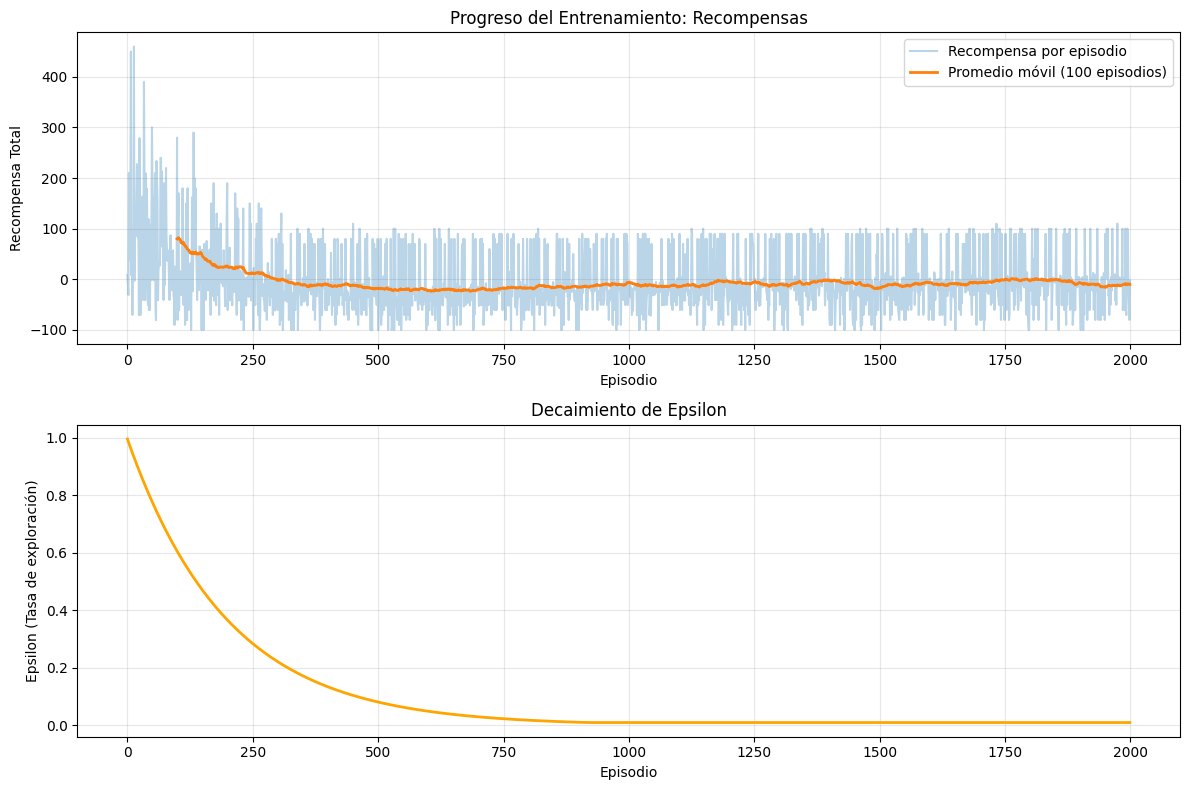


=== ESTADÍSTICAS FINALES ===
Recompensa promedio (últimos 100 episodios): -9.98
Recompensa máxima alcanzada: 460.00
Recompensa mínima: -100.20
Epsilon final: 0.0100


In [8]:
plot_training_progress(rewards_history, epsilon_history, window=100)

“El primer gráfico muestra cómo evoluciona la recompensa del agente episodio a episodio.  
Aunque hay mucha variabilidad, el promedio móvil indica que el agente no logra mejorar su rendimiento. Eso significa que no está aprendiendo una estrategia efectiva para Pac-Man.”  
  
“El segundo gráfico muestra el decaimiento de epsilon, que controla la exploración. Al inicio el agente explora totalmente, pero epsilon cae tan rápido que el agente deja de explorar antes de aprender algo útil. Esto provoca que se quede   atrapado en políticas subóptimas.”  
  
“La combinación de ambos gráficos sugiere que el agente necesita más exploración, mejor arquitectura o una señal de recompensa más informativa para poder aprender a jugar Pac-Man.”  

## Paso 9: ¡Ver al Agente Jugar!

Ahora vamos a ver cómo juega el agente entrenado con visualización gráfica.

**Nota**: Se abrirá una ventana de Pygame. Ciérrala cuando quieras terminar la evaluación.

In [9]:
# Crear nuevo entorno CON renderizado
env_render = PacmanEnv(grid_size=8, num_ghosts=2, render_mode='human')

# Evaluar agente con visualización
evaluate_agent(env_render, agent, num_episodes=5, render=True)


=== EVALUACIÓN DEL AGENTE ===
Episodio 1: Recompensa = 70.00, Pasos = 200
Episodio 2: Recompensa = 3.00, Pasos = 71
Episodio 3: Recompensa = -42.10, Pasos = 22
Episodio 4: Recompensa = -26.00, Pasos = 61
Episodio 5: Recompensa = -0.40, Pasos = 105

Recompensa promedio: 0.90
Tasa de éxito: 2/5 (40.0%)


## Paso 10: Experimentación

### Ejercicios para practicar:

1. **Cambiar parámetros del entorno:**
   - Aumenta el número de fantasmas
   - Cambia el tamaño del grid
   - Modifica las recompensas

2. **Ajustar hiperparámetros del agente:**
   - Prueba diferentes valores de `learning_rate`
   - Cambia `epsilon_decay` para explorar más o menos
   - Ajusta `discount_factor` (qué tanto valora el futuro)

3. **Mejoras al entorno:**
   - Agrega power-ups que permitan comer fantasmas
   - Crea fantasmas con diferentes comportamientos
   - Añade paredes al laberinto

4. **Mejoras al agente:**
   - Implementa Deep Q-Learning (DQN) usando redes neuronales
   - Añade memoria de repetición (replay buffer)
   - Prueba otros algoritmos como SARSA o Actor-Critic

## Resumen

### ¿Qué aprendimos?

1. **Aprendizaje por Refuerzo**: Cómo un agente aprende mediante prueba y error
2. **Q-Learning**: Algoritmo fundamental que aprende valores de estado-acción
3. **Gymnasium**: Cómo crear entornos personalizados
4. **Pygame**: Renderizado visual de juegos
5. **Exploración vs Explotación**: Balance entre probar cosas nuevas y usar lo aprendido

### Conceptos clave:
- **Estado**: Configuración actual del juego
- **Acción**: Movimiento que puede hacer el agente
- **Recompensa**: Feedback del entorno
- **Q-Table**: Tabla que guarda qué tan buena es cada acción en cada estado
- **Epsilon (ε)**: Probabilidad de exploración
- **Alpha (α)**: Tasa de aprendizaje
- **Gamma (γ)**: Importancia de recompensas futuras

¡Felicidades! Has creado tu primer agente de Aprendizaje por Refuerzo.